# Estimación de la entrada mediante Mínimos Cuadrados Recursivos

## Introducción

Los sensores, poseen una dinámica inherente que afecta su comportamiento, es decir. Esta dinámica puede dividirse en dos partes: la respuesta transitoria y la respuesta en estado estacionario. Generalmente, es en el estado estacionario donde la salida del sensor se relaciona linealmente con la variable de entrada, lo que facilita su uso en aplicaciones prácticas.

Tradicionalmente, se emplea la ganancia estática para estimar la entrada a partir de la salida en estado estacionario. Sin embargo, durante el periodo transitorio, esta aproximación puede generar errores significativos debido a la discrepancia entre la respuesta real y el modelo estacionario. Esto introduce un trade-off inherente entre la velocidad y la precisión del sensor: priorizar una respuesta rápida puede sacrificar precisión, mientras que buscar mayor exactitud puede aumentar el tiempo necesario para alcanzar el estado estacionario.

Sin embargo existen enfoques, como el diseño de compensadores, que buscan mejorar la dinámica de los sensores al filtrar o reducir la respuesta transitoria. Estos métodos pueden optimizar tanto la velocidad como la precisión del sensor, al permitir que su salida converja más rápidamente a la señal de entrada deseada. Por ejemplo, compensadores basados en controladores PID o filtros adaptativos. Estos enfoques no están exentos de limitaciones. En primer lugar, el diseño de compensadores requiere un modelado preciso de la dinámica del sensor. Otra desventaja es que, al tratar de mejorar la velocidad de respuesta, se puede amplificar el ruido de alta frecuencia, afectando la precisión global del sistema {cite}`AstromMurray2012`.

Por lo tanto, aunque los compensadores ofrecen ventajas significativas para mejorar la dinámica de los sensores, su implementación debe evaluarse cuidadosamente para garantizar que los beneficios superen los costos y riesgos asociados.


Por otro lado {cite}`gustavo_thesis`, nos presenta método basa en datos diseñado para un DSP, que es **la estimación directa de la entrada al escalón a partir de la respuesta a este del sensor**.  Como se menciona en {cite}`gustavo_thesis`, este método formula un problema de errores en variables (EIV) estructurado en Hankel con correlación. La matriz de regresión tiene una estructura de bloques de Hankel y la correlación existe porque la respuesta transitoria, perturbada por el ruido de medición (se asume que el reuido de medición tiene media cero y varianza finita), construye tanto la matriz de regresión como el regresor. Por lo que el método se implementa en tiempo real utilizando una solución de mínimos cuadrados recursivos del problema estructurado EIV. Este método tiene como principal ventaja que no es necesario el añadir el compensador, únicamente es necesaria la medición de la salida del sensor.


## Estimación de la entrada sin modelo del sistema

El método que se presenta a continuación, puede estimar el nivel de entrada al escalón, sin la necesidad de identificar el modelo del sensor. Este método es obtenido de {cite}`gustavo_thesis`.

Para derivar a este método, utilizamos el operador de diferencias finitas $\Delta$, el cual se define como:

$$\Delta y(k) = y(k + 1) - y(k)$$

Sea un sistema representado en espacio de estados, como se muestra a continuación:

$$\mathbf{x}(k+1) = \mathbf{A}\mathbf{x}(k) + \mathbf{B}u(k), \quad \mathbf{x}_{\text{ini}} = \mathbf{x}(0)$$

$$y(k) = \mathbf{Cx}(k) + Du(k) + \epsilon(k)$$

donde $\mathbf{A} \in \Re^{x \times n}$, $\mathbf{B} \in \Re^{n}$, $\mathbf{C} \in \Re^{1 \times n}$, y $D \in \Re$, son las matrices del modelo, $\epsilon$ es el ruido de medición y $n$ el orden del sistema.

Aplicando el operador $\Delta$ para una diferencia finita sobre el sistema antes presentado, resulta el siguiente sistema autonomo 

$$\mathbf{\Delta} \mathbf{x} (k + 1) = \mathbf{A}\mathbf{\Delta} \mathbf{x}(k), \quad  \Delta y(k) = \mathbf{C}\mathbf{\Delta}\mathbf{x}(k), \quad \mathbf{\Delta}\mathbf{x}_{\text{ini}} = \mathbf{\Delta}\mathbf{x}(0)$$

donde $\Delta u(k) = \mathbf{0}$, para $k\geq 0$, y $\mathbf{\Delta}\mathbf{x}(0) = (\mathbf{A} - \mathbf{I})\mathbf{x}(0) + \mathbf{B}u$

Si la respuesta $\Delta y$ de este sistema autónomo es de excitación persistente de orden $L$, entonces el rango de la matriz de Hankel $\mathbf{\mathcal{H}}_{L+1}(\Delta y)$, formada por $L + 1$ filas de bloques construidas a partir de $\Delta y$, satisface:

$$\text{rank} (\mathbf{\mathcal{H}}_{L+1}(\Delta y)) = \text{rank} \left\{\begin{pmatrix}
\Delta y(1) & \Delta y(2) &  \cdots & \Delta y(n) \\
\Delta y(2) & \Delta y(3) &  \cdots &  \Delta y(n+1) \\
\vdots & \vdots & \ddots & \vdots  \\
 \Delta y(L+1) &  \Delta y(L+2)  & \cdots &  \Delta y(L+N)
\end{pmatrix}\right\} \leq L$$

Como se indica en {cite}`gustavo_thesis`, se asume que la respuesta autónoma $\Delta y$ es de excitación persistente con un orden suficientemente alto. En este caso, la imagen de las columnas de la matriz de Hankel $\mathbf{\mathcal{H}}_{N-n}(\Delta y)$ forma un espacio lineal que contiene todas las respuestas naturales del sistema autónomo aumentado, como se muestra a continuación:

$$\mathbf{x}_a(k+1) = \begin{bmatrix}
\mathbf{A} & \mathbf{B}  \\
0 & 1 
\end{bmatrix} \mathbf{x}_a(k), \quad \text{donde } \mathbf{x}_a(k) = \begin{bmatrix}
\mathbf{x}(k)  \\
u(k) 
\end{bmatrix}, \quad \mathbf{x}_{\text{ini}}(k) = \mathbf{x}(0)$$
$$y(k) = \begin{bmatrix}
\mathbf{C} & D 
\end{bmatrix}\mathbf{x}_{a}(k) $$

entonces

$$\mathbf{y}_{\text{natural}} = \mathbf{\mathcal{H}}_{N-n}(\Delta y)\mathbf{\mathcal{l}},$$

para cualquier vector $\mathbf{\mathcal{l}} \in \Re^n$, dado que el sistema autónomo se deriva de un sistema lineal e invariante en el tiempo (LIT), al aumentar un estado y considerando que la entrada escalón forma parte de las condiciones iniciales, la respuesta total del sistema LIT es la suma de la respuesta forzada, debida a la entrada aplicada $u$, y la respuesta natural, generada a partir de la matriz de Hankel.

$$\mathbf{y} = \mathbf{y}_{forzada} + \mathbf{y}_{natural} = Gu + \mathbf{\mathcal{H}}(\Delta y)\mathbf{\mathcal{l}},$$

donde $G$ es la ganancia estática del sistema. Lo anterior es equivalente a 

$$\begin{bmatrix}
y(n+1)  \\
\vdots \\
y(N) 
\end{bmatrix} = \begin{bmatrix}
G & \Delta y(1) & \Delta y(2) & \dots &  \Delta y(n) \\
G & \Delta y(2) & \Delta y(3) & \dots & \Delta y(n+1) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
G &  \Delta y(N-n) & \Delta y(N-n+1) & \dots & \Delta y(N-1)
\end{bmatrix}\begin{bmatrix}
u  \\
 \mathbf{\mathcal{l}}
\end{bmatrix}$$

donde $N$ es el número de muestras. Según lo señalado en {cite}`gustavo_thesis`, el vector $\mathbf{\mathcal{l}}$ es una transformación lineal de las condiciones iniciales del sistema. La solución a este sistema de ecuaciones existe y es única cuando se cuenta con datos exactos. Sin embargo, en la práctica, las mediciones de los sensores siempre estarán contaminadas por perturbaciones.

Como se mencionó anteriormente, las observaciones del vector $\mathbf{y}$ están perturbadas por ruido de medición $\epsilon$, el cual tiene media cero y varianza $\sigma_{\epsilon}^2$. Podemos expresar entonces:

$$\hat{\mathbf{y}} = \mathbf{y} + \mathbf{\epsilon}, \quad \hat{\mathbf{K}} = \mathbf{K} + \mathbf{E}$$


La matriz $\mathbf{E}$ esta construida con los datos del ruido, y esta dado por

$$ \mathbf{E} = \begin{bmatrix}
0 & \Delta \epsilon(1) & \Delta \epsilon(2) & \dots &  \Delta \epsilon(n) \\
0 & \Delta \epsilon(2) & \Delta \epsilon(3) & \dots & \Delta \epsilon(n+1) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 &  \Delta \epsilon(N-n) & \Delta \epsilon(N-n+1) & \dots & \Delta \epsilon(N-1)
\end{bmatrix}$$

mientras que la matriz $\hat{\mathbf{K}}$ es expresada

$$ \hat{\mathbf{K}} = \begin{bmatrix}
G & \Delta \hat{y}(1) & \Delta \hat{y}(2) & \dots &  \Delta \hat{y}(n) \\
G & \Delta \hat{y}(2) & \Delta \hat{y}(3) & \dots & \Delta \hat{y}(n+1) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
G &  \Delta \hat{y}(N-n) & \Delta \hat{y}(N-n+1) & \dots & \Delta \hat{y}(N-1)
\end{bmatrix}$$

Por lo que el sistema resultante de las ecuaciones, es

$$\hat{\mathbf{y}} = \hat{\mathbf{K}}\mathbf{\theta}$$

que expresado como un problema de minimización

$$\hat{\mathbf{\theta}} = \text{argmin}_{\theta} \vert\vert  \hat{\mathbf{y}} - \hat{\mathbf{K}}\mathbf{\theta} \vert\vert_2^2$$

donde $\hat{\mathbf{y}} = \begin{bmatrix}
\hat{y}(n+1) & \dots & \hat{y}(N) 
\end{bmatrix}^T$, y $\hat{\mathbf{\theta}} = \begin{bmatrix}
\hat{u} &  \hat{\mathit{l}}^T 
\end{bmatrix}^T$. Este problema de minimización es un problema de *errores en las variables* (EIV) con estructura de Hankel y correlación entre la matriz de regresión $\hat{\mathbf{K}}$ y el vector de regresores $\hat{\mathbf{y}}$ {cite}`gustavo_thesis`.

El método de estimación de entrada por escalón basado en datos convierte el problema de identificación simultánea del modelo de error de salida y la estimación de entrada en un problema de estimación de entrada *errores en las variables* (EIV). El costo de evitar la modelización paramétrica del sensor es enfrentarse a un marco estocástico más complej {cite}`gustavo_thesis`.

Como podemos observar, este problema puede resolverse mediante mínimos cuadrados, siendo los mínimos cuadrados recursivos la opción más adecuada para implementar este método en línea. Esto es lo que exploraremos en este capítulo.

In [1]:
# Bibliotecas utilizadas
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

## Ejemplo de implementación del algoritmo

En {cite}`gustavo_thesis`, se presenta una implementación práctica de una celda de carga, a la que se le aplicó una masa conocida de $138.32 [g]$ y se realizó el proceso de adquisición de los datos. Para más información sobre el montaje experimental, el material empleado y la URL con los datos experimentales, consultar  {cite}`gustavo_thesis` A continuación, se cargarán los datos mencionados de dicha implementación experimental y se graficarán.

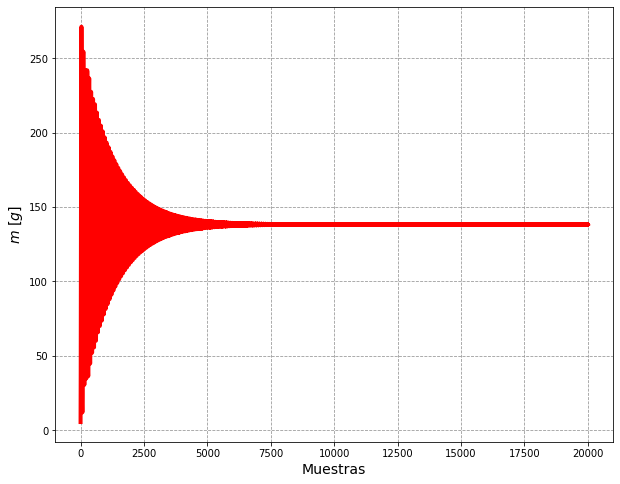

In [2]:
# Carga de los datos guardados previamente en un csv
mass = np.loadtxt('sources/data_mass.csv', delimiter = ',')

# Gráfica de los datos experimentales completos
plt.figure(figsize=(10, 8))
plt.plot(mass, 'r-', linewidth=4)
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.show()

En la gráfica superior podemos ver los datos experimentales obtenidos en {cite}`gustavo_thesis`, correspondientes a 20,000 muestras. Sin embargo, para poder visualizarlos mejor, a continuación graficaremos las primeras 4,000 muestras.

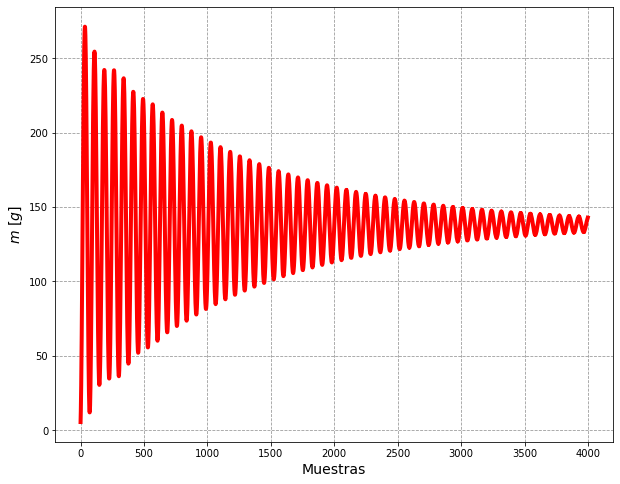

In [3]:
# Gráfica de los datos experimentales completos
plt.figure(figsize=(10, 8))
plt.plot(mass[:4000], 'r-', linewidth=4)
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.show()

```{note}
A continuación se presentarán las funciones necesarias para poder emplear este método en `Python`, dichas funciones estan basadas en las proporcionadas en el URL de {cite}`gustavo_thesis`, las cuales se encuentran en `MATLAB`.
```

Una vez obtenidos los datos de las mediciones, le añadiremos el ruido de medición, con una relación señal-ruido (SNR)  de $50 [dB]$. Para esto, construiremos la siguiente función *add_noise*.

In [4]:

def add_noise(y0, wanted_SNR):
    """
    Agrega ruido a la señal y0 para alcanzar un SNR deseado.

    Parámetros:
    y0: array_like
        Señal original.
    wanted_SNR: float
        Relación señal-ruido deseada en dB.

    Retorna:
    y: array_like
        Señal con ruido agregado.
    """
    T = len(y0)
    SNRini = 20
    SNR = SNRini
    s = 1e-2
    s_delta = 1e-3

    def compute_snr(signal, noise):
        """Calcula la relación señal-ruido (SNR) en dB."""
        signal_power = np.mean(signal**2)
        noise_power = np.mean(noise**2)
        return 10 * np.log10(signal_power / noise_power)

    # Ajustar el nivel de ruido para alcanzar el SNR inicial
    while SNR >= SNRini:
        noise = s * np.random.randn(T)
        SNR = compute_snr(y0, noise)
        s += s_delta

    # Refinar el nivel de ruido para alcanzar el SNR deseado
    while SNR < wanted_SNR:
        s -= s_delta
        noise = s * np.random.randn(T)
        SNR = compute_snr(y0, noise)

    # Generar la señal con ruido añadido
    noise = s * np.random.randn(T)
    y = y0 + noise

    return y 

Por lo que ahora, una vez construida la función para añadir ruido a las mediciones, con una relación señal a ruido de $50 [dB]$, hacemos uso de esta función y guardamos las nuevas meidiciones ruidosas en `mass_noise`

In [5]:
mass_noise = add_noise(mass, 50)

A continuación se presentan las funciones necesarias para el uso de este método, incluido el algoritmo de mínimos cuadrados recursivo.

In [6]:

def blkhank(dy, Tt, n):
    """
    Genera una matriz Hankel con bloques a partir de un vector de datos.

    Parámetros:
    dy : ndarray
        Vector de diferencias (de tamaño (N, 1) o (N,)).
    Tt : int
        Número de filas deseadas para la matriz Hankel.

    Retorna:
    hankel_matrix : ndarray
        Matriz Hankel de bloques con tamaño (Tt, n).
    """
    hankel_matrix = np.zeros((Tt, n))  # Inicializar matriz con ceros
    for i in range(Tt):
        hankel_matrix[i, :] = dy[i:i + n, 0]  # Selección de bloques consecutivos
    return hankel_matrix

def rls(a, b, lambda_):
    """
    Implementación optimizada de mínimos cuadrados recursivos (RLS).

    Parámetros:
    a : ndarray
        Matriz de regresores.
    b : ndarray
        Vector de salidas.
    lambda_ : float
        Factor de olvido.

    Retorna:
    theta : ndarray
        Estimación de parámetros a lo largo del tiempo.
    """
    m, n = a.shape  # Dimensiones de la matriz de regresores

    # Inicialización de parámetros
    theta = np.zeros((n, m))
    P = np.eye(n) * 1e6  # Matriz de covarianza inicializada con valores grandes
    phi = 0

    for i in range(m):
        phi = a[i, :].reshape(-1, 1)  # Vector de regresores actual (como columna)
        epsilon = b[i] - np.dot(phi.T, theta[:, i - 1])  # Error de predicción

        # Ganancia de Kalman
        K = np.dot(P, phi) / (lambda_ + np.dot(np.dot(phi.T, P), phi))

        # Actualización de la matriz de covarianza
        P -= np.dot(np.dot(K, phi.T),  P)
        P *= (1 / lambda_)  # Aplicar el factor de olvido

        # Actualización del vector de parámetros
        theta[:, i] = theta[:, i - 1] + (K * epsilon).flatten() 

    return theta



def stepid_dd(y, g, n, ff):
    """
    Estimación de la entrada a escalón unitario mediante un algoritmo RLS.

    Args:
        y (np.ndarray): Vector columna de mediciones(salidas del sistema).
        g (float): Ganancia estática.
        n (int): Orden del sistema.
        ff (float): Factor de olvido del algoritmo RLS.

    Returns:
        np.ndarray: Estimación de la entrada escalón `uh` con ajuste de retardo. 
                    Los primeros `n` valores estarán llenos de NaN para alinear con el retardo.
    """
    # Asegurar que y sea un vector columna
    y = np.atleast_2d(y).T

    # Diferencias entre elementos consecutivos
    dy = np.diff(y, axis=0)
    dy = np.vstack(([0], dy))  # Asegurar alineación con y

    T = y.shape[0]  # Longitud de la serie y
    Tt = T - n  # Ajuste por retardo
    yt = y[n:T, :].T  # Salidas desplazadas según el retardo

    # Crear matriz Hankel de bloques
    hankel_matrix = blkhank(dy, Tt, n)

    # Resolver con RLS
    g_vector = np.ones((Tt, 1)) * g
    regresores = np.hstack((g_vector, hankel_matrix))
    
    x = rls(regresores, yt.ravel(), ff)
    

    # Estimación de la entrada escalón
    m = g_vector.shape[1]
    uh = x[:m, ::m].T
    uh = np.vstack((np.full((n, m), np.nan), uh))  # Ajuste de tamaño

    return uh

Ahora, podemos ver que la última función construida tiene como parámetros las observaciones de la salida con ruido de medición, la ganancia estática del sistema, que se considerará unitaria, el orden del sensor, que asumiremos como en {cite}`gustavo_thesis`, es decir, de séptimo orden, y finalmente un factor de olvido unitario, lo que significa que trabajaremos con mínimos cuadrados recursivos ordinarios.

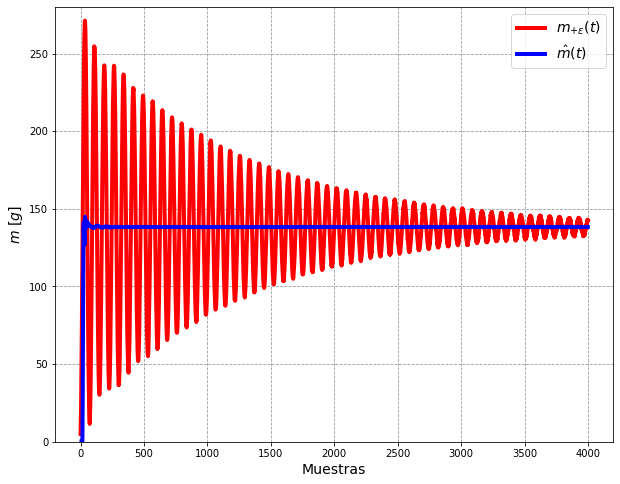

In [7]:
G = 1
n = 7
lambda_ = 1
mass_estimated = stepid_dd(mass_noise[:4000], G, n, lambda_)

plt.figure(figsize=(10, 8))
plt.plot(mass_noise[:4000], 'r-', linewidth=4, label=r'$m_{+\epsilon}(t)$')
plt.plot(mass_estimated, 'b-', linewidth=4, label=r'$\hat{m}(t)$')
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.legend(fontsize=14)
plt.ylim([0, 280])
plt.show()


Como podemos apreciar, rápidamente el algoritmo converge al valor de la entrada. Sin embargo, al compararlo con la salida, puede no ser tan evidente. Por lo tanto, en la siguiente figura se muestra la entrada estimada junto con la entrada real y el desarrollo del error absoluto porcentual entre la entrada real y la estimada.

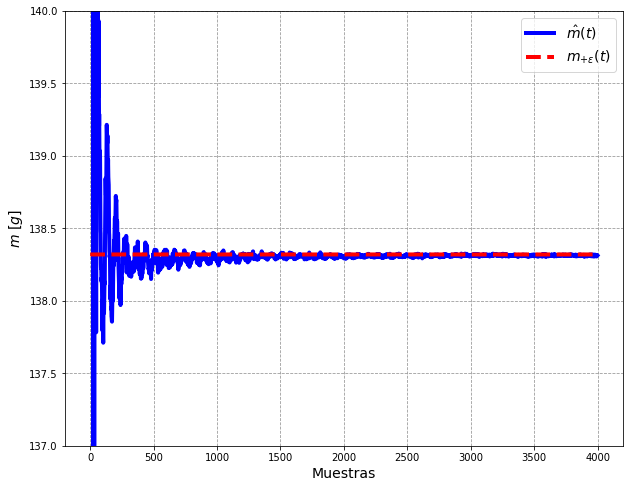

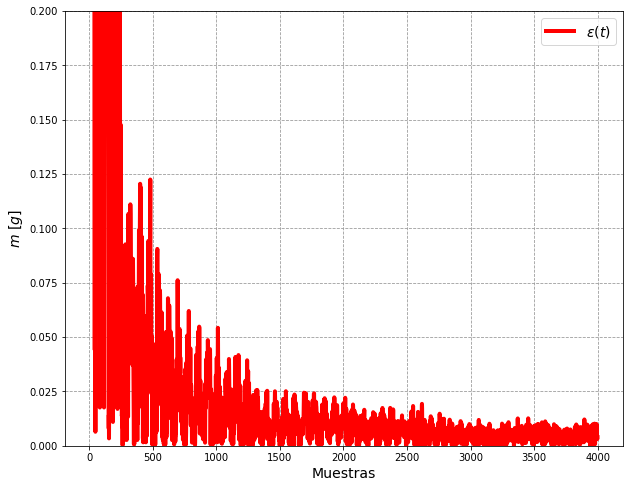

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(mass_estimated, 'b-', linewidth=4, label=r'$\hat{m}(t)$')
plt.plot(138.32 * np.ones(len(mass_estimated)),
          'r--', linewidth=4, label=r'$m_{+\epsilon}(t)$')
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.legend(fontsize=14)
plt.ylim([137, 140])
plt.show()

error = [np.abs((138.32 - m_est)/138.32)*100 for m_est in mass_estimated]
plt.figure(figsize=(10, 8))
plt.plot(error, 'r-', linewidth=4, label=r'$\epsilon(t)$')
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.legend(fontsize=14)
plt.ylim([0, 0.2])
plt.show()

Como podemos apreciar, el error absoluto porcentual, rápidamente es menor al $0.2\%$

## Implementación en un caso práctico

Para simular de mejor manera el funcionamiento del sensor del caso anterior, tomamos los datos los datos proporcionados en {cite}`gustavo_thesis`, y utilizando el `System Identification Toolbox` de `MATLAB`, se obtuvo una función de transferencia de segundo orden que aproxima el comportamiento del sensor real. Por lo que la función de transferencia del sensor es

$$H(s) = \frac{108400}{s^2 + 6.567s + 108400}$$

Una vez obtenida esta función, se someterá a un proceso de discretización, utilizando el retenedor de orden cero. Con la ecuación en diferencias, se simularán las mediciones del sensor ante la siguiente entrada.

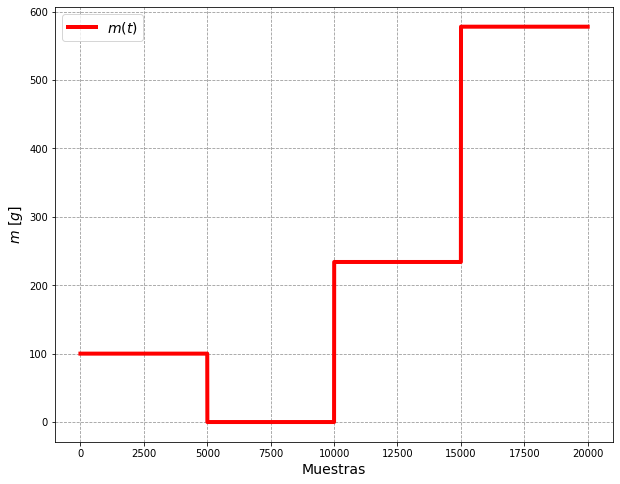

In [9]:
t = np.arange(0, 20000)
signal = np.zeros_like(t)  # Inicializar la señal con ceros

# Asignar valores a los intervalos
signal[(t >= 0) & (t < 5000)] = 100
signal[(t >= 5000) & (t < 10000)] = 0
signal[(t >= 10000) & (t < 15000)] = 234
signal[(t >= 15000) & (t < 20000)] = 578


plt.figure(figsize=(10, 8))
plt.plot(signal, 'r-', linewidth=4, label=r'$m(t)$')
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

La siguiente señal, simulará el siguiente caso práctico:
1. Se coloca una masa de $100 g$ sobre el sensor, para luego retirarla.
2. Unos momentos después, se coloca otra masa de $234 g$.
3. Instantes más tarde, sobre la masa ya añadida, se coloca otra de $344 g$, resultando en una masa total sobre el sensor de $578 g$.

Como se puede apreciar en la dinámica del sensor, para obtener una medición precisa, es necesario esperar demasiado tiempo. Por lo tanto, si esperamos al estado estacionario para realizar la medición, resultará poco práctico. Es por esto que implementaremos el método bajo estudio.

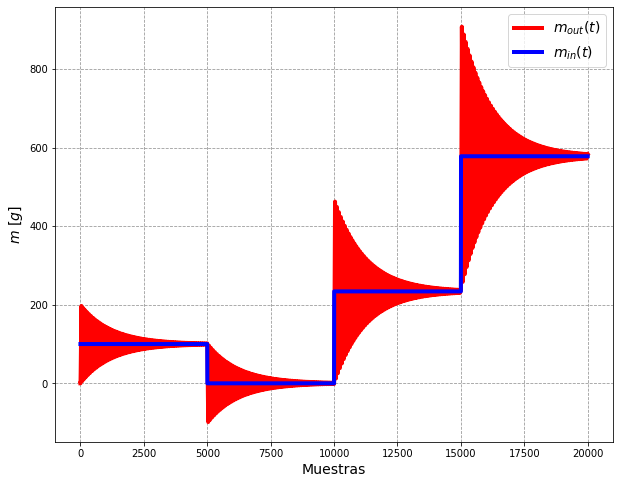

In [10]:
# Definir el sistema continuo
num = [1.084e05]
den = [1, 6.567, 1.084e05]
system = tf(num, den)

# Convertir a tiempo discreto usando Zero-Order Hold (ZOH)
Ts = 1 / 4000  # Tiempo de muestreo
system_d = c2d(system, Ts, method='zoh')

# Extraer los coeficientes del numerador y denominador
numd, dend = system_d.num[0][0], system_d.den[0][0]
y = [0, 0]
for n in range (2, len(signal)):
    out = numd[0]*signal[n] + numd[1]*signal[n] - dend[1]*y[n-1] - dend[2]*y[n-2]
    y.append(out)

y = np.array(y)
plt.figure(figsize=(10, 8))
plt.plot(y, 'r-', linewidth=4, label=r'$m_{out}(t)$')
plt.plot(signal, 'b-', linewidth=4, label=r'$m_{in}(t)$')
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [11]:
# Añadiendo ruido a la señal de entrada
y_noise = add_noise(y, 50)


Como podemos apreciar en la figura anterior, en cada una de las mediciones es necesario esperar más de la mitad de las muestras para obtener una medición relativamente precisa. Por lo tanto, a continuación se empleará el algoritmo presentado con las siguientes características:
1. Ganancia estática $G=1$.
2. Orden del sensor $n = 7$.
3. Factor de olvido $\lambda = 0.991$

En este caso, a diferencia del anterior, la señal de salida presenta cambios considerables, por lo que el factor de olvido se modifica, utilizando mínimos cuadrados recursivos con factor de olvido.

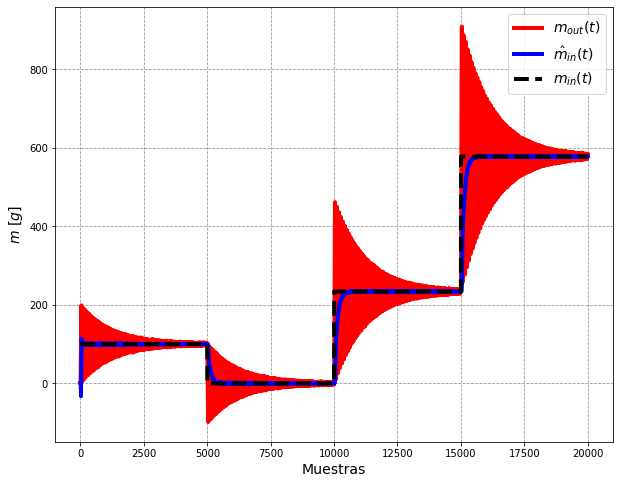

In [12]:
# Parámetros a modificar si desean
n = 7
lambda_ = 0.991


G = 1
y2 = stepid_dd(y_noise, G, n, lambda_)
plt.figure(figsize=(10, 8))
plt.plot(y_noise, 'r-', linewidth=4, label=r'$m_{out}(t)$')
plt.plot(y2, 'b-', linewidth=4, label=r'$\hat{m}_{in}(t)$')
plt.plot(signal, 'k--', linewidth=4, label=r'$m_{in}(t)$')
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$m\ [g]$', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Como podemos apreciar, este método basado en datos, le provee al sensor la capacidad de estimar la entrada a partir de mediciones ruidosas de la salida, esto con el mínimo error posible, por lo que resulta práctico para aplicaciones en tiempo real.